# Nested sampling

### Christian Holm Christensen

Like Markov-chain Monte-Carlo methods, nested sampling is a way to find the prior that best describes the data, given a likelihood function.  Here, we will do some simple tests. 

Here, we will use the Python package _nestle_.  If not already available, install with 

    pip3 install nestle 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import nestle as ns

## Egg-box

The egg-box example is a classic example and provides stress-testing for many nested sampling algorithms.  The likelihood is given by 

$$L(\theta) = \prod_i\cos\theta_i\quad.$$

In [2]:
def likelihood(theta):
    from numpy import multiply, cos
    return multiply.reduce(cos(theta))

Let us plot this likelihood over $(x,y)\in[0,4\pi]\times[0,4\pi]$.  Note, this is essentially the same as doing a scan, except it is more precise and not so heavy on the computer. 

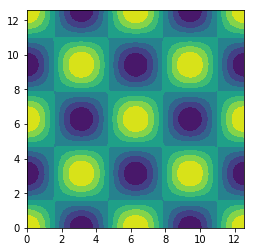

In [3]:
x = np.linspace(0,2*2*np.pi)
xx,yy = np.meshgrid(x,x)
zz    = likelihood(np.array([xx,yy]))
plt.contourf(xx,yy,zz)
plt.gca().set_aspect(1);

We need to provide the _prior transform_ according the nested sampling prescription.  That is, this function must transform the prior domain $[0,1]^n$, where $n$ is the dimensionality of the problem, into the domain of the likelihood function (here  $n=2$ and the domain of the likelihood is $[0,4\pi]\times[0,4\pi]$)

In [4]:
def prior(x):
    from numpy import pi
    return 2*2*np.pi*x

Now we can run the nested sampling algorithm to obtain a _posteriori_ at some sampling points. 

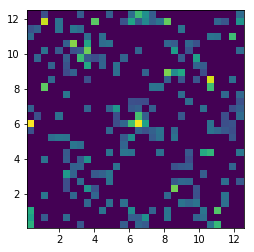

In [5]:
res = ns.sample(likelihood,prior,2)
plt.hist2d(*res.samples.T,30,weights=res.weights)
plt.gca().set_aspect(1);

## Circular Normal distributions

Let us look at a circular Normal likelihood 

$$ L(\theta;c,r,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}e^{-\frac12\frac{\left(|\theta-c|-r\right)^2}{\sigma^2}}\quad,$$ 

where $c,r$ is the centre and radius of the circle, respectively, and $\sigma$ is the width of the normal distribution.  In general, $\theta,c\in\mathbb{R}^n$, while $r,\sigma\in\mathbb{R}$.  Here, we will consider $n=2$ only. 

First, let us define a single circle as a function

In [6]:
def circ(theta,c,r,sigma):
    from numpy import sqrt,exp,pi,atleast_1d,newaxis,ndim
    from numpy.linalg import norm
    cc = atleast_1d(c)
    if len(theta.shape) == 3:
        cc = cc[:,newaxis,newaxis]
    elif len(theta.shape) == 2:
        cc = cc[:,newaxis]
    
    ntc = norm(theta-cc,axis=0)
    
    ret = 1/(np.sqrt(2*pi)*sigma)*exp(-1/2*(ntc-r)**2/sigma**2)
    return ret

Next, we define the sum of $n$ normal circles, each with its own centre $c_i$, radius $r_i$, and width $\sigma_i$

In [7]:
def ncirc(theta,c,r,sigma):
    from numpy import add 
    
    return add.reduce([circ(theta,cc,rr,ss) 
                       for cc,rr,ss in zip(c,r,sigma)])

We essentially want to do the same thing a few times:

- Plot the likelihood function over some domain $D\subseteq\mathbb{R}^n$ 
- Define a prior transformation that maps $[0,1]^n$ to $D$
- Performs the nested sampling 
- Plots the _posterior_ over $D$

We write a function that does that. 

In [8]:
def run_nested(likelihood,lower,upper,ngrid=30,nbins=30,**kwargs):
    from numpy import linspace, meshgrid, array,ndim,atleast_1d
    from matplotlib.pyplot import subplots
    from nestle import sample 
    
    ll = atleast_1d(lower)
    uu = atleast_1d(upper)
    
    nvar = len(lower)
    if nvar < 3:
        fig,ax = plt.subplots(ncols=2,sharey=True,sharex=True,
                             gridspec_kw=dict(wspace=.01))
        x      = linspace(ll[0],uu[0],ngrid)
        y      = linspace(ll[1],uu[1],ngrid)
        xx,yy  = meshgrid(x,y)
        zz     = likelihood(array([xx,yy]))
        ax[0].contourf(xx,yy,zz)
        ax[0].set_title('Likelihood')
        aa = (uu-ll)[1]/(uu-ll)[0]
        ax[0].set_aspect(aa)
        
    def prior_transform(x):
        return (uu-ll) * x + ll
    
    res = sample(likelihood,prior_transform,nvar,**kwargs)
    print(res.summary())
    
    if nvar < 3:
        ax[1].hist2d(*res.samples.T,nbins,weights=res.weights)
        ax[1].set_title('Posterior')
        ax[1].set_aspect(aa)

### A single circle
We make a single normal circle at $c=(2.5,3.1),r=2,\sigma=0.1$ and run the nested sampling using the above function.   

niter: 360
ncall: 2774
nsamples: 460
logz:  1.298 +/-  0.112
h:  1.250


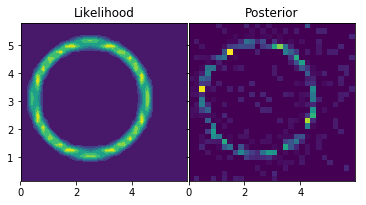

In [9]:
one = lambda theta: circ(theta,(2.5,3.1),2,0.1)
run_nested(one,(0,0),(6,6))

### Two overlapping circles 

niter: 642
ncall: 5812
nsamples: 742
logz:  2.329 +/-  0.168
h:  2.806


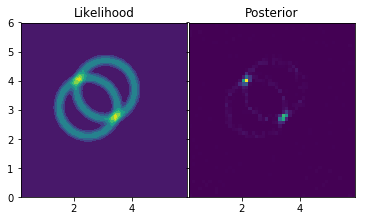

In [10]:
overl = lambda theta: circ(theta,(2.5,3.1),1,0.1)+circ(theta,(3.1,3.7),1,0.1)
run_nested(overl,(0,0),(6,6),ngrid=50,nbins=50)

### Concentric circles

niter: 325
ncall: 1892
nsamples: 425
logz:  1.663 +/-  0.112
h:  1.257


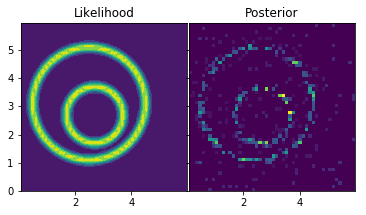

In [11]:
conc = lambda theta : circ(theta,(2.5,3.1),2,0.1)+circ(theta,(2.7,2.7),1,.1)
run_nested(conc,(0,0),(6,6),ngrid=50,nbins=50)